## Multilabel Classification

Objective: How  well  can  we  classify  a  restaurant’s  cuisine  type  using  the content of their reviews as input?

### Imports

In [14]:
import numpy as np
import pandas as pd
import regex as re
import nltk
import warnings
warnings.filterwarnings('ignore')
import sys, os

#Preprocessing
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from pipeline import main_pipeline
from preproc import multilabel_preproc

from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from textblob import TextBlob
sent_tokenizer = PunktSentenceTokenizer()

#Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

### Datasets

In [15]:
reviews = pd.read_csv('C:/Users/msard/OneDrive/Desktop/Data Science/Fall 2024/Text Mining/Hyderabadi-Word-Soup/data_hyderabad/10k_reviews.csv')
restaurants = pd.read_csv('C:/Users/msard/OneDrive/Desktop/Data Science/Fall 2024/Text Mining/Hyderabadi-Word-Soup/data_hyderabad/105_restaurants.csv')

In [16]:
reviews = multilabel_preproc(reviews, restaurants)

In [17]:
reviews.head()

,Review,Cuisines
0,"The ambience was good, food was quite good . h...","[Chinese, Continental, Kebab, European, South ..."
1,Ambience is too good for a pleasant evening. S...,"[Chinese, Continental, Kebab, European, South ..."
2,A must try.. great food great ambience. Thnx f...,"[Chinese, Continental, Kebab, European, South ..."
3,Soumen das and Arun was a great guy. Only beca...,"[Chinese, Continental, Kebab, European, South ..."
4,Food is good.we ordered Kodi drumsticks and ba...,"[Chinese, Continental, Kebab, European, South ..."


<Figure size 1000x600 with 0 Axes>

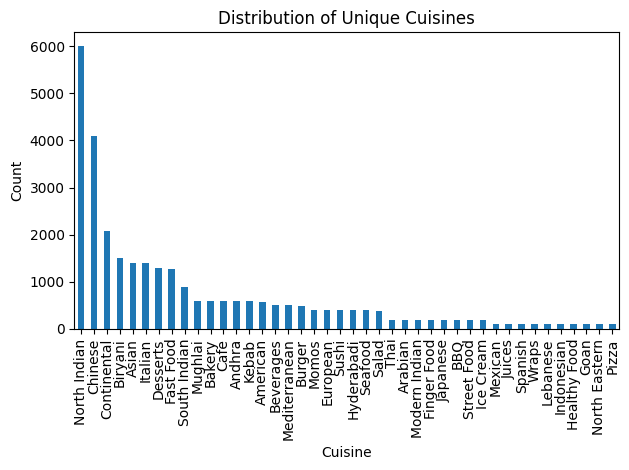

In [7]:
# Flatten the list of cuisines
all_cuisines = [cuisine for sublist in reviews['Cuisines'] for cuisine in sublist]

# Count the occurrences of each unique cuisine
cuisine_counts = Counter(all_cuisines)

# Convert the counts to a DataFrame for easier plotting
cuisine_counts_df = pd.DataFrame(cuisine_counts.items(), columns=['Cuisine', 'Count'])

# Plot the distribution of unique cuisines
plt.figure(figsize=(10, 6))
cuisine_counts_df.sort_values(by='Count', ascending=False).plot(kind='bar', x='Cuisine', y='Count', legend=False)
plt.title('Distribution of Unique Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Testing

#### Basic review preprocessing

In [8]:
preprocessor = MainPipeline()

In [9]:
reviews['Preproc_Review'] =\
      reviews['Review'].map(lambda content: preprocessor.main_pipeline(content))

#### Vectorization

In [10]:
#TF-IDF
vectorizer = TfidfVectorizer()
reviews_tfidf_matrix = vectorizer.fit_transform(reviews['Preproc_Review'])


reviews['tfidf_vector'] = reviews_tfidf_matrix.toarray().tolist()
reviews_tfidf_matrix.shape #(documents, features)

(9955, 16148)

In [11]:
#Doc2Vec
# We need first to put the reviews in a tagged document object, with a (word, tag) shape
review_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews['Preproc_Review'].apply(str.split))]

doc2vec = Doc2Vec(review_docs, vector_size=100, window=2, min_count=1, workers=4)
reviews_doc2vec_matrix = [doc2vec.infer_vector(doc.split()) for doc in reviews['Preproc_Review']]

reviews['doc2vec_vector'] = reviews_doc2vec_matrix

reviews_doc2vec_matrix = np.array(reviews_doc2vec_matrix)
reviews_doc2vec_matrix.shape #(documents, embedding dimensionality)

(9955, 100)

In [23]:
reviews_doc2vec_matrix

array([[-0.10034175,  0.01705779,  0.01810839, ..., -0.02255409,
        -0.02309818, -0.02365983],
       [-0.04085062,  0.02805782,  0.0052786 , ..., -0.02636021,
        -0.00137968,  0.02083321],
       [-0.07284533,  0.12864608, -0.00712314, ..., -0.06313963,
        -0.02066616,  0.07652414],
       ...,
       [-0.37878102,  0.04463977, -0.03798933, ..., -0.3850417 ,
        -0.35406983,  0.18162169],
       [-0.05592767,  0.08538455,  0.14533089, ...,  0.00295795,
         0.02952765, -0.02340039],
       [-0.16170828,  0.09348275, -0.09955607, ..., -0.06485627,
        -0.16296741, -0.06258969]], dtype=float32)

Creating the labels matrix

In [12]:
mlb = MultiLabelBinarizer()
binarised_labels = mlb.fit_transform(reviews["Cuisines"])
reviews["cuisine_binary"] = binarised_labels.tolist()

# mlb.inverse_transform(binarised_labels)
binarised_labels.shape #(documents, labels)

(9955, 42)

### Model Testing

We use SGDClassifier because it is more efficient and scalable than Logistic Regression for high-dimensional datasets like this. Unlike Logistic regression, which loads the entire dataset into memory, SGD processes data in mini-batches using stochastic gradient descent, making it memory-efficient. It also handles sparse data, trains faster on large datasets, and supports incremental learning, which is ideal for text classification tasks with high feature counts.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(reviews_doc2vec_matrix, binarised_labels,
                                                test_size=0.2, random_state=0, shuffle=True)

#### One vs Rest

In [14]:
# Define and train the SGD-based OneVsRest classifier
ovr = OneVsRestClassifier(SGDClassifier(loss="log_loss", random_state=0, class_weight="balanced"))
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(class_weight='balanced',
                                            loss='log_loss', random_state=0))

In [15]:
# Predict
y_pred_ovr = ovr.predict(X_test)
# mlb.inverse_transform(y_pred_ovr)
fold_score_calculator(y_pred_ovr, y_test, verbose=True)

Accuracy: 0.0 
Precision: 0.3452840682379434 
Recall: 0.6747967479674797 
F1: 0.4131658600915541


(0.0, 0.3452840682379434, 0.6747967479674797, 0.4131658600915541)

#### Classifier Chain

In [17]:
#Test the classifier Chain
cchain = ClassifierChain(SGDClassifier(loss="log_loss", random_state=0, class_weight="balanced"), order="random")
cchain.fit(X_train, y_train)

ClassifierChain(base_estimator=SGDClassifier(class_weight='balanced',
                                             loss='log_loss', random_state=0),
                order='random')

In [18]:
y_pred_cchain = cchain.predict(X_test)
# mlb.inverse_transform(y_pred_q1_cchain)
fold_score_calculator(y_pred_cchain, y_test, verbose=True)

Accuracy: 0.005022601707684581 
Precision: 0.3197704815031068 
Recall: 0.21951219512195122 
F1: 0.21201694216815792


c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.005022601707684581,
 0.3197704815031068,
 0.21951219512195122,
 0.21201694216815792)

### Model Optimization

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels


class HermeticClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, preprocessor, vectorizer, classifier, d2v_vector_size=300, d2v_window=6, **kwargs):
        self.preprocessor = preprocessor
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.d2v_vector_size = d2v_vector_size
        self.d2v_window = d2v_window

    def fit(self, X, y, **kwargs):

        X_preproc = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X]

        try:
            X_train = self.vectorizer.fit_transform(X_preproc)
        except AttributeError:
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]
            self.d2v_model = self.vectorizer(documents, vector_size=300, window=6, min_count=1, workers=4)
            X_train = [self.d2v_model.dv[idx].tolist() for idx in range(len(X_preproc))]

        y_train = y
            
        try:
            X_train = X_train.toarray()
        except AttributeError:
            pass
        try:
            y_train = y_train.to_numpy()
        except AttributeError:
            pass

        #X_train, y_train = check_X_y(X_train, y_train)

        self.classifier.fit(X_train, y_train)

        self.X_ = X_train
        self.y_ = y_train

        return self

    def predict(self, X_test_raw, **kwargs):

        # Check if fit has been called
        check_is_fitted(self)

        X_test = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X_test_raw]

        try:
            X_test = self.vectorizer.transform(X_test)
        except AttributeError:
            X_test = [self.d2v_model.infer_vector(word_tokenize(content)).tolist() for content in X_test]

        try:
            X_test = check_array(X_test.toarray())
        except AttributeError:
            X_test = check_array(X_test)
            
        y_pred = self.classifier.predict(X_test)

        return y_pred
    

In [20]:
X_train, X_test, y_train, y_test = train_test_split(reviews["Review"], binarised_labels,
                                                    test_size=0.2, random_state=0)


In [26]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b") 
cch_lr = ClassifierChain(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced"), order="random")
preprocessor = MainPipeline()

hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, cch_lr)

In [27]:
hermetic_classifier.fit(X_train,y_train)
y_pred_q2 = hermetic_classifier.predict(X_test)
y_pred_q2_translated = mlb.inverse_transform(y_pred_q2)
fold_score_calculator(y_pred_q2,y_test, verbose=True)

Accuracy: 0.08287292817679558 
Precision: 0.43662137145430296 
Recall: 0.5258005641280903 
F1: 0.45775451919519167


(0.08287292817679558,
 0.43662137145430296,
 0.5258005641280903,
 0.45775451919519167)

In [ ]:
d2v = Doc2Vec 
ml_class = ClassifierChain(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced"), order="random")
preprocessor = MainPipeline(no_stopwords=False,lemmatized=False)

hermetic_classifier2 = HermeticClassifier(preprocessor, d2v, ml_class)

hermetic_classifier2.fit(X_train,y_train)

HermeticClassifier(classifier=ClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                random_state=0),
                                              order='random'),
                   preprocessor=MainPipeline(lemmatized=False,
                                             no_stopwords=False),
                   vectorizer=<class 'gensim.models.doc2vec.Doc2Vec'>)

In [ ]:
y_pred_q22 = hermetic_classifier2.predict(X_test)
y_pred_q22_translated = mlb.inverse_transform(y_pred_q22)
fold_score_calculator(y_pred_q22,y_test,verbose=True)

Accuracy: 0.011551983927674536 
Precision: 0.17820360022069023 
Recall: 0.031027044964327195 
F1: 0.026244358093880066


c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.011551983927674536,
 0.17820360022069023,
 0.031027044964327195,
 0.026244358093880066)

### Grid Search Optimization

In [ ]:
# Vectorizers
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
bigram_bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
doc2vec_vectorizer = Doc2Vec

# Classifiers
class_ovr = OneVsRestClassifier(LogisticRegression())
class_cc = ClassifierChain(LogisticRegression())

# Preprocessor (assuming MainPipeline is defined elsewhere)
preprocessor = MainPipeline()

# HermeticClassifier (assuming HermeticClassifier is defined elsewhere)
hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, class_ovr)

# Parameter grid
parameter_grid = {
    'preprocessor__no_stopwords': [True, False],
    'preprocessor__lemmatized': [True, False],
    'preprocessor__lowercase': [True, False],
    'vectorizer': [doc2vec_vectorizer, bigram_tfidf_vectorizer, bigram_bow_vectorizer],
    'classifier': [class_ovr, class_cc],
    'classifier__estimator__solver': ['lbfgs'],
    'classifier__estimator__C': [10, 1, 0.1],
    'classifier__estimator__penalty': [None, 'l2'],
    'classifier__estimator__class_weight': [None, 'balanced'],
    'classifier__estimator__random_state': [1],
    'classifier__estimator__multi_class': ["ovr", "multinomial"],
    'd2v_vector_size': [300],
    'd2v_window': [20, 5]
}

# Scoring metrics
scores = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]

# Grid search
grid_search = GridSearchCV(hermetic_classifier, parameter_grid, scoring=scores, verbose=4, refit="f1_weighted")

# Fit the model
grid_result = grid_search.fit(reviews["Review"], binarised_labels)
scores = ["accuracy","precision_weighted","recall_weighted","f1_weighted"]

grid_search = GridSearchCV(hermetic_classifier, parameter_grid, scoring=scores, verbose=4, refit="f1_weighted")

grid_result = grid_search.fit(reviews["Review"], binarised_labels)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
[CV 1/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=None, classifier__estimator__multi_class=ovr, classifier__estimator__penalty=None, classifier__estimator__random_state=1, classifier__estimator__solver=lbfgs, d2v_vector_size=300, d2v_window=20, preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=<class 'gensim.models.doc2vec.Doc2Vec'>; accuracy: (test=nan) f1_weighted: (test=nan) precision_weighted: (test=nan) recall_weighted: (test=nan) total time=  38.3s
[CV 2/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=None, classifier__estimator__multi_class=ovr, classifier__estimator__penalty=None, classifier__estimator__random_state=1, classifier__estimator__solver=lbfgs, d2v_vector_size=300, d2v_wi

KeyboardInterrupt: 

In [ ]:
grid_result.best_params_

NameError: name 'grid_result' is not defined

In [ ]:
## Best results
for score in scores:
    print("{} = {}".format(score,round(grid_result.cv_results_['mean_test_{}'.format(score)][grid_result.best_index_],3)))

### Comparing against Dummy

In [ ]:
preprocessor = MainPipeline()
dummy_classifier = ClassifierChain(DummyClassifier())
bigram_bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
hermetic_classifier3 = HermeticClassifier(preprocessor, bigram_bow_vectorizer, dummy_classifier)

parameter_grid = {'preprocessor__no_stopwords':[True],
                  'preprocessor__lemmatized':[True],
                  'preprocessor__lowercase':[True],                  
                  'vectorizer':[bigram_bow_vectorizer],
                  'classifier':[dummy_classifier],
                  'classifier__base_estimator__strategy':["most_frequent", "prior", "stratified", "uniform", "constant"]}

grid_search2 = GridSearchCV(hermetic_classifier3, param_grid=parameter_grid, scoring=scores, verbose=4, refit="f1_weighted")

grid_result2 = grid_search2.fit(reviews["Review"], binarised_labels)

In [ ]:
## Best results
for score in scores:
    print("{} = {}".format(score,round(grid_result2.cv_results_['mean_test_{}'.format(score)][grid_result2.best_index_],3)))

## Neural Networks

In this section, we attempt to use CNN and RNN, using pre-trained GLOvE embeddings.

In [ ]:
# Embedding matrix

# Loading pre-trained GloVe embeddings
embedding_index = {}
with open('path/to/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Creating the embedding matrix
vocab_size = len(reviews['Preproc_Review'])
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():  # word_index is a dictionary mapping words to their indices
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input
from tensorflow.keras.models import Model

# Parameters
max_sequence_length = 100
vocab_size = 20000
embedding_dim = 100
embedding_matrix = np.random.rand(vocab_size, embedding_dim)
all_cuisines = [cuisine for sublist in reviews['Cuisines'] for cuisine in sublist]
num_classes = len(all_cuisines)

model = tf.keras.Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [25]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

ValueError: Invalid dtype: object

In [ ]:
# Assuming y_test and y_pred are the true and predicted labels respectively

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

# Hamming Loss
hamming = hamming_loss(y_test, y_pred)

# Subset Accuracy
subset_accuracy = np.mean(np.all(y_test == y_pred, axis=1))

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Hamming Loss: {hamming}")
print(f"Subset Accuracy: {subset_accuracy}")